# 3. Tiedon korjaukset

## 3.1 Geometriakorjaukset

### 3.1.1 Shapely explain_validity

<span style="color:red">**Tämä vaihe ei ole pakollinen!**</span>

Geometriakorjauksissa ETL-työkalu nojaa vahvasti Pythonin [Shapely-kirjastoon](https://shapely.readthedocs.io/en/stable/manual.html). Kaavaindekseille voidaan ajaa explain_validity-funktio, joka palauttaa tekstikenttänä tiedon, mikäli geometria itsessään on epävalidi. Esimerkiksi, jos kaavaindeksi risteää itseään, funktio palauttaa tekstikentän “Ring Self-intersection” sekä ongelmallisen sijainnin koordinaatit. Lisäksi voidaan laskea validien geometrioiden prosenttiosuus.

In [ ]:
# Käytettävien Python moduulien ja kehitettyjen funktioiden sisäänluku
import geopandas as gpd
from lib.geometry_validity import checkGeometryValidity, calculateGeometryValidityPercentage
from lib.accessory_functions import saveGPKG

In [ ]:
# Lue master geopackagesta kaavatietoja, esim. kuntien yleiskaavat
data = gpd.read_file(r"<insert filepath here>.gpkg", layer="yleiskaavat_kunta")

# Tarkista geometrioiden oikeellisuus
data_validity = checkGeometryValidity(data=data, geom_column='geometry')

# Tulosta tulokset
print(data_validity['validity'].value_counts())

In [ ]:
# Voit myös laskea validien geometrioiden prosenttiosuuden
calculateGeometryValidityPercentage(data_validity)

# Et tarvitse 'validity' tietoa jatkossa, joten voit pudottaa sen skeemasta pois
data_validity = data_validity.drop(columns=['validity'])

### 3.1.2 Shapely make_valid

Mikäli kaavaindeksin geometria on virheellinen, se korjataan Shapelyn make_valid-funktiolla. **Funktio voidaan ajaa riippumatta siitä, onko geometrialle korjaustarvetta tai ei!**

Monissa korjaustapauksissa make_valid-funktio räjäyttää alkuperäisen geometrian useaksi kohteeksi, jotta geometriasta saadaan validi. Jos räjäytyksessä luodaan useampi kohde samalla geometriatyypillä, funktio palauttaa multi-geometriaa (MultiPolygon). Jos taas korjauksessa luodaan kohteita, joilla on eri geometriatyyppi, palautetaan GeometryCollection. Kaavojen tapauksessa vain aluemaiset geometriat ovat sallittuja, joten ETL-työkalu käsittelee mahdollisesti esiin nousevat GeometryCollectionit automaattisesti ja palauttaa ne aluemaisiksi (MultiPolygon/Polygon).

In [ ]:
# Kehitettyjen funktioiden sisäänluku
from lib.repair_dataset_geometries import repairDatasetGeometries

In [ ]:
# Korjaa geometria tarvittaessa
data_repaired = repairDatasetGeometries(data=data_validity, geom_column='geometry')

# Tallenna korjattu geometriatieto
saveGPKG(data_repaired, outputfp=r"<insert filepath here>.gpkg", layer_name="yleiskaavat_kunta")

### 3.1.3 Muut geometriakorjaukset

Erään kunnan osalta CAD-aineiston paikkatietokonversio tuotti kaavaindekseille päällekkäisiä “haamugeometrioita”. ETL-työkalu filteröi nämä päällekkäisyydet aineiston osalta pois ominaisuustietovertailuun pohjautuen erillisellä skriptillä.

Tähän tapaukseen voi käydä tutustumassa erikseen VOOKA-hankkeen [GitHub-sivujen kautta](https://github.com/ubigu/vooka). Erillisskriptit löytyvät muut-kansiossa. 

## 3.2 Yleiskaavojen kuntarajatörmäykset

### 3.2.1 Toleranssi-raja-arvot

Kuntien yleiskaavojen ulkorajat noudattelevat kiinteistörajoista muodostettua kuntarajaa vaihtelevalla tarkkuudella. Tästä johtuen VOOKA-projektissa tunnistettiin jokaisen Etelä-Savon kunnan osalta parhaiten toimiva tolaranssi-raja-arvo, jonka avulla kunnan yleiskaavarajat saadaan suoristettua suhteessa kiinteistörajoista muodostettuun kuntarajaan. **Muilla maantieteellisillä alueilla raja-arvot voivat olla hyvinkin erilaiset riippuen lähtöaineiston topologisesta laadusta! Suositeltava ensimmäinen testiarvo on 0.015!**

Suluissa kuntakoodi:
- Enonkoski (046): no data
- Hirvensalmi (097): 0.00009
- Juva (178): 0.015
- Kangasniemi (213): 0.015
- Mikkeli (491): 0.005
- Mäntyharju (507): 0.015
- Pertunmaa (588): 0.0005
- Pieksämäki (593): no data
- Puumala (623): 0.015
- Rantasalmi (681): 0.015
- Sulkava (768): 0.0005
- Savonlinna (740): 0.05

Näitä raja-arvoja on syytä käyttää ETL-prosessissa.

### 3.2.2 Eksklaavien käsittely

Joillakin kunnilla voi olla palstoja varsinaisten hallinnollisten kuntarajojen ulkopuolella. Tällaiset palstat muodostavat ETL-prosessissa turhia ekslaaveja, joita ei haluta ottaa kuntarajakorjauksissa huomioon.

Jos eksklaaveja halutaan filteröidä pois, tulee snapKuntakaavaToKuntaraja-funktiolle antaa valinnainen parametri "remove_exclaves"=True.

### 3.2.3 Enklaavien käsittely

#### 3.2.3.1 Kuntaenklaavit

Suomen maakunnissa voi esiintyä tilanteita, joissa yksi kunta on toisen kunnan enklaavi. Tällainen erityistapaus löytyy Etelä-Savosta Enonkosken ja Savonlinnan väliltä. ETL-työkalu osaa käsitellä kuntaenklaavit automaattisesti.

Jos jollakin kunnalla on kuntaenklaavi, tulee snapKuntakaavaToKuntaraja-funktiolle antaa valinnainen parametri "kuntakoodi_remove_enclave"="enklaavin kuntakoodi". Mikäli parametria ei anneta, kuntarajakorjauksissa alue täyttyy virheellisesti.

<p>
    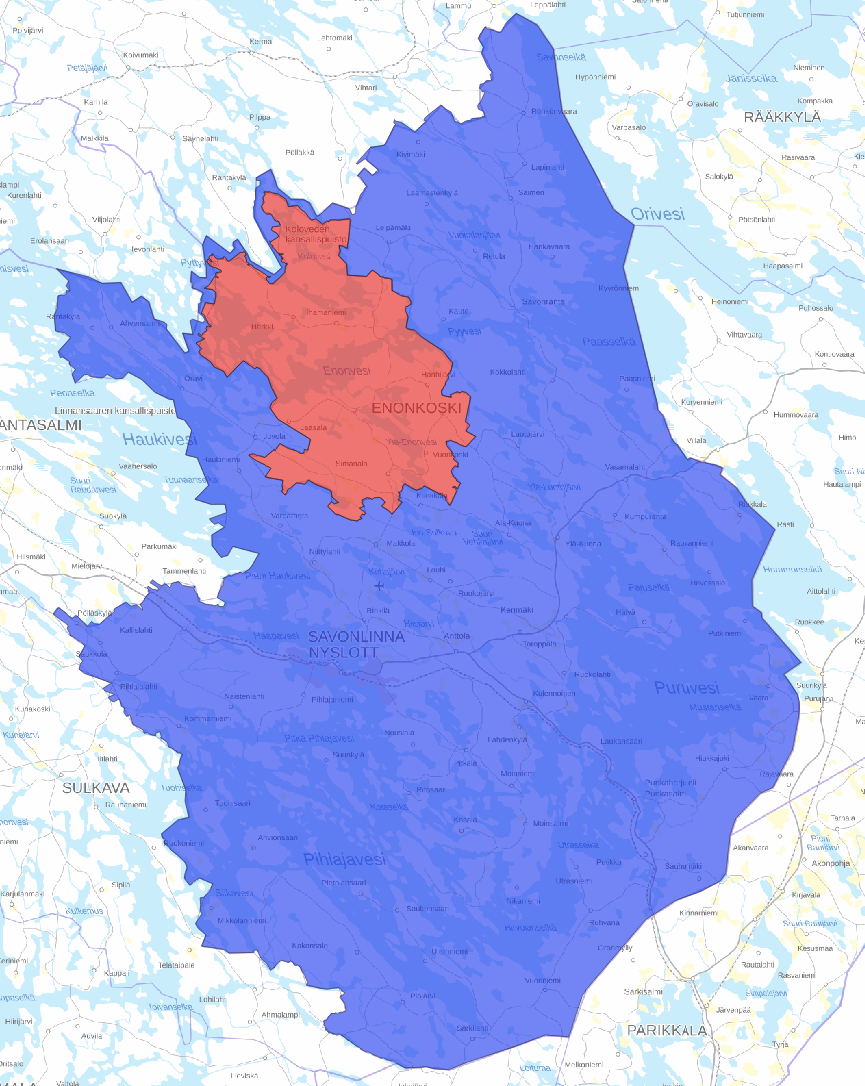
</p>

#### 3.2.3.2 Kiinteistörajaenklaavit

Kunnan sisällä voi lisäksi olla kiinteistöpalstoja, joiden omistus on toisella kunnalla. Näissä tilanteissa snapKuntakaavaToKuntaraja-funktiolle tulee antaa valinnainen parametri "fill_holes"=False. Mikäli toisen kunnan omistuksessa olevia kiinteistöpalstoja ei esiinny kunnan sisällä, parametria ei tarvitse ilmoittaa ETL-työkalulle.

### 3.2.4 Kuntarajojen korjaus

In [ ]:
# Kehitettyjen funktioiden sisäänluku
from lib.accessory_functions import readPickleData
from lib.kaava_to_kuntaraja import snapKuntakaavaToKuntaraja

In [ ]:
# Kuntien yleiskaavat ja MML:n kiinteistöpalsta-aineisto, josta muodostetaan kunkin kunnan ulkorajat
palstat = readPickleData(inputfp=r"<insert filepath here>.pkl")
kunta_kaavadata = gpd.read_file(r"<insert filepath here>.gpkg", layer="yleiskaavat_kunta")

In [ ]:
# Kuntarajojen oikaisu kunta kerrallaan! Katso lisätiedot parametreista kaava_to_kuntaraja.py docstringista!

# Funktio palauttaa kaikki annetun kaavadatan rivit korjaten kuntakoodin mukaisen kunnan yleiskaavarajat
# Lisää "fill_holes", remove_exclaves" tai "kuntakoodi_remove_enclave" -parametri tarvittaessa!

kunta_kaavadata = snapKuntakaavaToKuntaraja(kaavadata=kunta_kaavadata,
                                            palstadata=palstat,
                                            kuntakoodi='<insert kuntakoodi here>',
                                            tolerance=0.015) #Vaihda kunnan mukaan!

In [ ]:
# Tallennus, kun kaikkien kuntien yleiskaavarajat on korjattu
saveGPKG(kunta_kaavadata, outputfp=r"<insert filepath here>.gpkg", layer_name="yleiskaavat_kunta")

## 3.3 Ominaisuustietokorjaukset

Päivämäärät (esim. kaavan hyväksymispäivämäärä ja voimaantulopäivämäärä) voi olla ilmoitettu kunnilta saaduissa kaava-aineistoissa hyvin vaihtelevissa muodoissa sekä osin puutteellisina. Eri kunnilla voi olla käytössä päivämääräformaatteina mm. DD.KK.YYYY, YYYYKKDD sekä YYYY. Lisäksi tieto voi olla ilmoitettu päivämäärä-tietotyypin sijasta tekstikenttänä (string).

ETL-prosessissa on mukana funktio, joka kääntää tekstimuodossa olevan tabulaarisen tiedon date-tietotyypiksi notaatiolla DD.KK.YYYY. Mikäli lähtötietona on ainoastaan vuosi, päivämääräksi annetaan kyseisen vuoden tammikuun ensimmäinen päivä.

In [ ]:
# Kehitettyjen funktioiden sisäänluku
from lib.accessory_functions import stringColumnToDate

In [ ]:
# Lue master geopackagesta haluamasi data
data_date = gpd.read_file(r"<insert filepath here>.gpkg", layer="<insert layer here>")

# Korjaa tarvittavat päivämäärät, jokaisen osalta esim:
data_1 = stringColumnToDate(input_df=data_date, date_column='hyvaksymispvm')
data_2 = stringColumnToDate(input_df=data1, date_column='vahvistamispvm')
data_repaired = stringColumnToDate(input_df=data_2, date_column='voimaantulopvm')

# Tallenna korjattu tieto
saveGPKG(data_repaired, outputfp=r"<insert filepath here>.gpkg", layer_name="<insert layer here>")